In [1]:
import math
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xlrd
from matplotlib.mlab import PCA as mlabPCA
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

from IPython.display import display, HTML


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

def my_plot_loop(X,y):
    
    list_features = X.columns
    listlength = len(list_features)+1
    f, axes = plt.subplots(listlength, 3, sharey=False, sharex=False , figsize=(20,20))
    y_var = y.name
    
    i = 1
    for column in list_features:
        plt.subplot(listlength, 3, i)
        sns.scatterplot(X[column],y)

        plt.subplot(listlength, 3, i+1)
        sns.boxplot(X[column] )

        plt.subplot(listlength, 3, i+2)
        #plt.title(column)
        plt.xlabel(column)
        plt.hist(X[column], bins="auto")
        i = i + 3

    #Plot Y Variable
    plt.subplot(listlength, 3, i)
    sns.scatterplot(y,y)

    plt.subplot(listlength, 3, i+1)
    sns.boxplot(y )

    plt.subplot(listlength, 3, i+2)
    #plt.title(column)
    plt.xlabel(y_var)
    plt.hist(y, bins="auto")
    return None
    

def my_run_linear_regression(X, Y):
    
    df = pd.merge(X, pd.DataFrame(Y), how='inner', left_index=True, right_index=True)
    feature_list = X.columns
    y_var = Y.name
    
    # Write out the model formula.
    # Your dependent variable on the right, independent variables on the left
    # Use a ~ to represent an '=' from the functional form
    #linear_formula = 'y_var ~ TV+Radio+Newspaper'
    last_feature = len(feature_list) - 1
    linear_formula = y_var + ' ~ '
    i = 0
    for feature in feature_list:
        if i == last_feature:
            linear_formula = linear_formula + feature_list[i]
        else:
            linear_formula = linear_formula + feature_list[i] + '+'

        i=i+1
 
    print(linear_formula + '\n')
    # Fit the model to our data using the formula.
    lm = smf.ols(formula=linear_formula, data=df).fit()
    
    #Load results into a df to display
    results_df = pd.DataFrame({'Parameter': lm.params, 
                     'P-Value' : lm.pvalues})
    
    print(results_df)
    print('')
    #print('R-Squared: ' + str(lm.rsquared))      

In [2]:
def my_pre_processing(raw, pop_cutoff):

    raw.columns = ['City','Population','Violent_Crime','Murder','Rape1','Rape2','Robbery','Assault',
                   'Property_Crime','Burglary','Larceny_Theft','Vehicle_Theft','Arson']
    df = pd.DataFrame(raw)


    #Data Cleaning
    df.at[df['Rape2'].isna() , 'Rape2'] =  df['Rape1']  
    df.drop(columns='Rape1', axis=1, inplace=True)
    df.dropna(subset=['Population'],inplace=True)
    df['Arson'] = np.where(df.Arson.isnull(),0,1)
    df = df[df.Population < pop_cutoff]

    #Feature Engineering
    #df['Murder'] = np.where(df.Murder > 0, 1, 0)
    df['Murder_Sqrt'] = np.sqrt(df.Murder)
    df['Violent_Crime_Sqrt'] = df.Violent_Crime ** (1/2)
    df['Population_Square'] = np.square(df.Population)
    df['Population_Sqrt'] = np.sqrt(df.Population)
    df['Robbery_Sqrt'] = np.sqrt(df.Robbery)
    df['Assault_Sqrt'] = np.sqrt(df.Assault)
    df['Property_Crime_Sqrt'] = np.sqrt(df.Property_Crime)
    df['Property_Crime_Square'] = np.square(df.Property_Crime)
    df['Rape2_Sqrt'] = np.sqrt(df.Rape2)
    df['Robbery_Assault_Sum'] = df.Assault + df.Robbery

    df['pop_size'] = pd.cut(raw.Population, [0, 15000, 75000, 1000000, 99999999999],  
                          labels=["small","medium","large","mill"])
    pop_dummies = pd.get_dummies(df['pop_size'])
    df = pd.merge(df, pop_dummies, left_index=True, right_index=True, how='inner')

    
    #myfeaturelist
    feature_list = ['Population_Sqrt','Rape2_Sqrt','Robbery_Assault_Avg_Sqrt', 'LargeCity']
    feature_list = ['Population_Sqrt','Rape2_Sqrt','Robbery_Sqrt','Assault']
    feature_list = ['small','large','mill','hundredk','Robbery_Assault_Sum_Sqrt']
    feature_list = ['Population_Square','Rape2','Robbery_Assault_Sum', 'small','large']
    y_var = 'Property_Crime'
    

    print('Cities processing: {}'.format(df.shape[0]))
    print('Cities Removed due to pop above {}: '.format(pop_cutoff))
    pop_remove_list = raw.loc[raw.Population > pop_cutoff,['City','Population']].sort_values(
        'Population', ascending=False)
    if pop_remove_list.shape[0] == 0:
        print('None')
    else:
        print(pop_remove_list)
    
  
    print('\nCities removed due to Null: ')
    null_list = df.isnull().any(axis=1)
    null_list = null_list[null_list.values==True]
    print(len(null_list))
    
    #print(df[df.isnull().any(axis=1)].index)  #,['City','Population']])
    df.dropna(inplace=True)

    X = df[feature_list]
    Y = df[y_var]
    #sns.boxplot(df.Population)
    return X, Y

def my_create_linear_regr(X,Y):
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)

    # Run model a second way using StatsModel to get the P-Values of each parameter
    my_run_linear_regression(X,Y)
    print('R-Squared: {}'.format(regr.score(X, Y)))
    return regr

#Check for assumption: multivariate normality
def my_explore_residuals(predicted_y, actual_y):
    fig = plt.figure(figsize=(10,3))

    # Calculate the error, also called the residual.
    residual = actual_y - predicted_y

    fig.add_subplot(121)
    plt.hist(residual)
    plt.title('Residual counts')
    plt.xlabel('Residual')
    plt.ylabel('Count')

    fig.add_subplot(122)
    plt.scatter(predicted_y, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')

    plt.show()

----------------------------------------------------
--------------------- TRAINING ---------------------
----------------------------------------------------
------- Pre-Process Training Data -----------
file_train: table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls
file_train: table_8_offenses_known_to_law_enforcement_georgia_by_city_2013.xls
file_train: table_8_offenses_known_to_law_enforcement_illinois_by_city_2013.xls
file_train: table_8_offenses_known_to_law_enforcement_california_by_city_2013.xls
file_train: table_8_offenses_known_to_law_enforcement_utah_by_city_2013.xls
file_train: table_8_offenses_known_to_law_enforcement_kentucky_by_city_2013.xls
file_train: table_8_offenses_known_to_law_enforcement_colorado_by_city_2013.xls
Cities processing: 1985
Cities Removed due to pop above 1000000: 
             City  Population
216      New York 8396126.000
1351  Los Angeles 3878725.000
684   Chicago3, 4 2720554.000
1470    San Diego 1349306.000

Cities removed due to

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


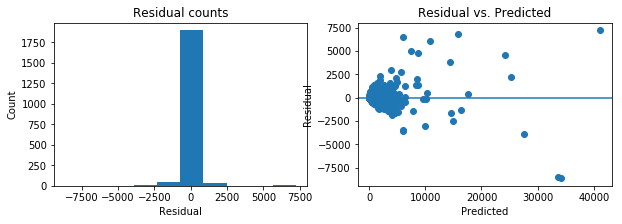

----------------------------------------------------
---------------------- TEST # 1 ---------------------
----------------------------------------------------
file: table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls
Cities processing: 347
Cities Removed due to pop above 1000000: 
         City  Population
216  New York 8396126.000

Cities removed due to Null: 
0
R Squared: 0.9037200124926436


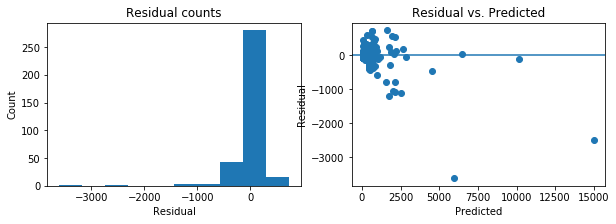

----------------------------------------------------
---------------------- TEST # 2 ---------------------
----------------------------------------------------
file: table_8_offenses_known_to_law_enforcement_georgia_by_city_2013.xls
Cities processing: 253
Cities Removed due to pop above 1000000: 
None

Cities removed due to Null: 
0
R Squared: 0.9213296871216533


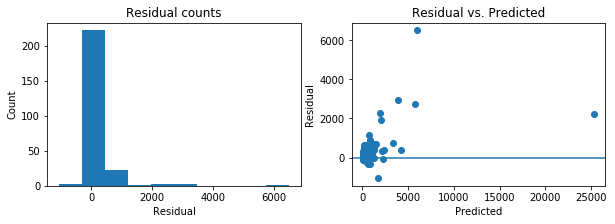

----------------------------------------------------
---------------------- TEST # 3 ---------------------
----------------------------------------------------
file: table_8_offenses_known_to_law_enforcement_illinois_by_city_2013.xls
Cities processing: 505
Cities Removed due to pop above 1000000: 
           City  Population
77  Chicago3, 4 2720554.000

Cities removed due to Null: 
0
R Squared: 0.7963358715274659


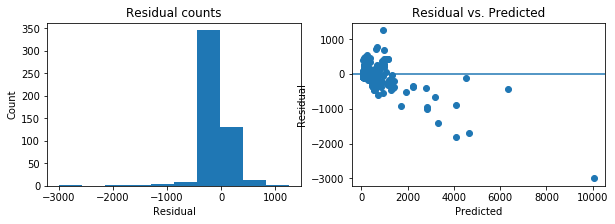

----------------------------------------------------
---------------------- TEST # 4 ---------------------
----------------------------------------------------
file: table_8_offenses_known_to_law_enforcement_alabama_by_city_2013.xls
Cities processing: 196
Cities Removed due to pop above 1000000: 
None

Cities removed due to Null: 
1
R Squared: 0.9315341317565912


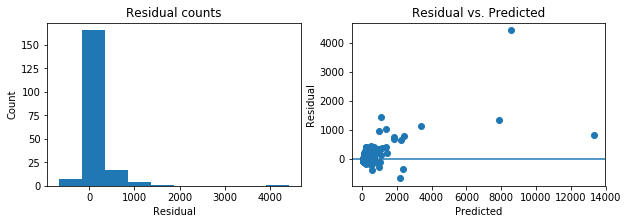

----------------------------------------------------
---------------------- TEST # 5 ---------------------
----------------------------------------------------
file: table_8_offenses_known_to_law_enforcement_washington_by_city_2013.xls
Cities processing: 182
Cities Removed due to pop above 1000000: 
None

Cities removed due to Null: 
0
R Squared: 0.8238075138192604


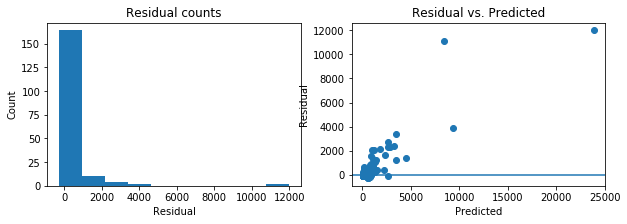

----------------------------------------------------
---------------------- TEST # 6 ---------------------
----------------------------------------------------
file: table_8_offenses_known_to_law_enforcement_ohio_by_city_2013.xls
Cities processing: 343
Cities Removed due to pop above 1000000: 
None

Cities removed due to Null: 
1
R Squared: 0.9400928218203343


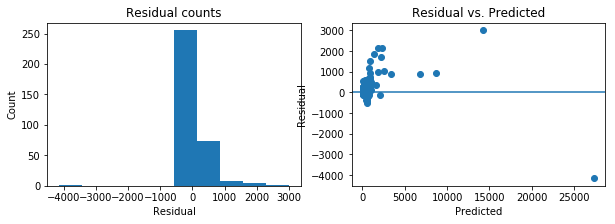

In [3]:
file1 = 'table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls'
file2 = 'table_8_offenses_known_to_law_enforcement_georgia_by_city_2013.xls'
file3 = 'table_8_offenses_known_to_law_enforcement_illinois_by_city_2013.xls'
file4 = 'table_8_offenses_known_to_law_enforcement_california_by_city_2013.xls'
file5 = 'table_8_offenses_known_to_law_enforcement_utah_by_city_2013.xls'
file6 = 'table_8_offenses_known_to_law_enforcement_kentucky_by_city_2013.xls'
file7 = 'table_8_offenses_known_to_law_enforcement_colorado_by_city_2013.xls'
file8 = 'table_8_offenses_known_to_law_enforcement_alabama_by_city_2013.xls'
file9 = 'table_8_offenses_known_to_law_enforcement_washington_by_city_2013.xls'
file10 = 'table_8_offenses_known_to_law_enforcement_ohio_by_city_2013.xls'

train_files = [file1, file2, file3, file4, file5, file6, file7]
test_files = [file1, file2, file3, file8, file9, file10 ]
pop_cutoff = 1000000

colnames = ['City','Population','Violent_Crime','Murder','Rape1','Rape2','Robbery','Assault',
                   'Property_Crime','Burglary','Larceny_Theft','Vehicle_Theft','Arson']

raw = pd.DataFrame(columns=colnames)

print('----------------------------------------------------')
print('--------------------- TRAINING ---------------------')
print('----------------------------------------------------')
print('------- Pre-Process Training Data -----------')
for file in train_files:
    print('file_train: {}'.format(file))   
    raw = pd.concat([raw, pd.read_excel(file, skiprows=4, names=colnames, usecols=12)],ignore_index=True )

train_X, train_Y = my_pre_processing(raw, pop_cutoff = pop_cutoff)

print('\n--------- Create Model -----------')
model = my_create_linear_regr(train_X, train_Y)

print('\n--------- Explore Results of Train Data -----------\n')
print('R Squared: {}'.format(model.score(train_X,train_Y)))
predicted_y = model.predict(train_X).ravel()
my_explore_residuals(predicted_y, train_Y)


i = 1
for file in test_files:
    print('----------------------------------------------------')
    print('---------------------- TEST # {} ---------------------'.format(i))
    print('----------------------------------------------------')
    print('file: {}'.format(file))
    raw_test = pd.read_excel(file, skiprows=4, usecols=12)
    #pre-process data
    test_X, test_Y = my_pre_processing(raw_test, pop_cutoff = pop_cutoff)
    #get results
    print('R Squared: {}'.format(model.score(test_X,test_Y)))
    predicted_y = model.predict(test_X).ravel()
    my_explore_residuals(predicted_y, test_Y)
    i = i + 1
    

In [4]:
raw.head()

,City,Population,Violent_Crime,Murder,Rape1,Rape2,Robbery,Assault,Property_Crime,Burglary,Larceny_Theft,Vehicle_Theft,Arson
0,Adams Village,1861.000,0.000,0.000,nan,0.000,0.000,0.000,12.000,2.000,10.000,0.000,0.000
1,Addison Town and Village,2577.000,3.000,0.000,nan,0.000,0.000,3.000,24.000,3.000,20.000,1.000,0.000
2,Akron Village,2846.000,3.000,0.000,nan,0.000,0.000,3.000,16.000,1.000,15.000,0.000,0.000
3,Albany,97956.000,791.000,8.000,nan,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,nan
4,Albion Village,6388.000,23.000,0.000,nan,3.000,4.000,16.000,223.000,53.000,165.000,5.000,nan


                     Population_Square  Rape2  Robbery_Assault_Sum  small  \
Population_Square                1.000  0.667                0.715 -0.154   
Rape2                            0.667  1.000                0.700 -0.311   
Robbery_Assault_Sum              0.715  0.700                1.000 -0.272   
small                           -0.154 -0.311               -0.272  1.000   
large                            0.346  0.513                0.495 -0.399   

                     large  
Population_Square    0.346  
Rape2                0.513  
Robbery_Assault_Sum  0.495  
small               -0.399  
large                1.000  


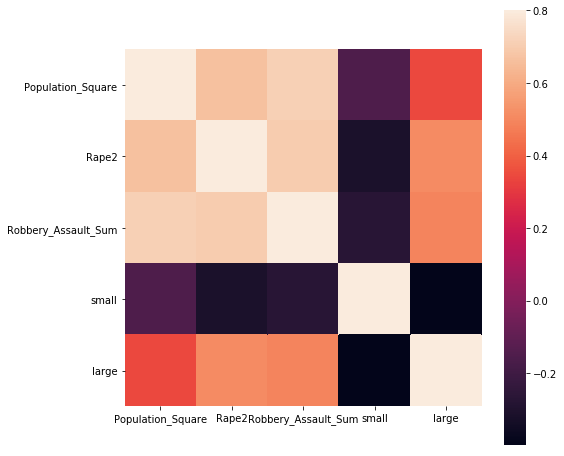

In [5]:
#Feature Selection - Check for multicollinearity
corrmat = train_X.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(8, 8))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()


In [6]:
print(train_X.shape)
print(train_X.columns)

(1983, 5)
Index(['Population_Square', 'Rape2', 'Robbery_Assault_Sum', 'small', 'large'], dtype='object')


In [7]:
print(train_Y.shape)
print(train_Y.name)

(1983,)
Property_Crime


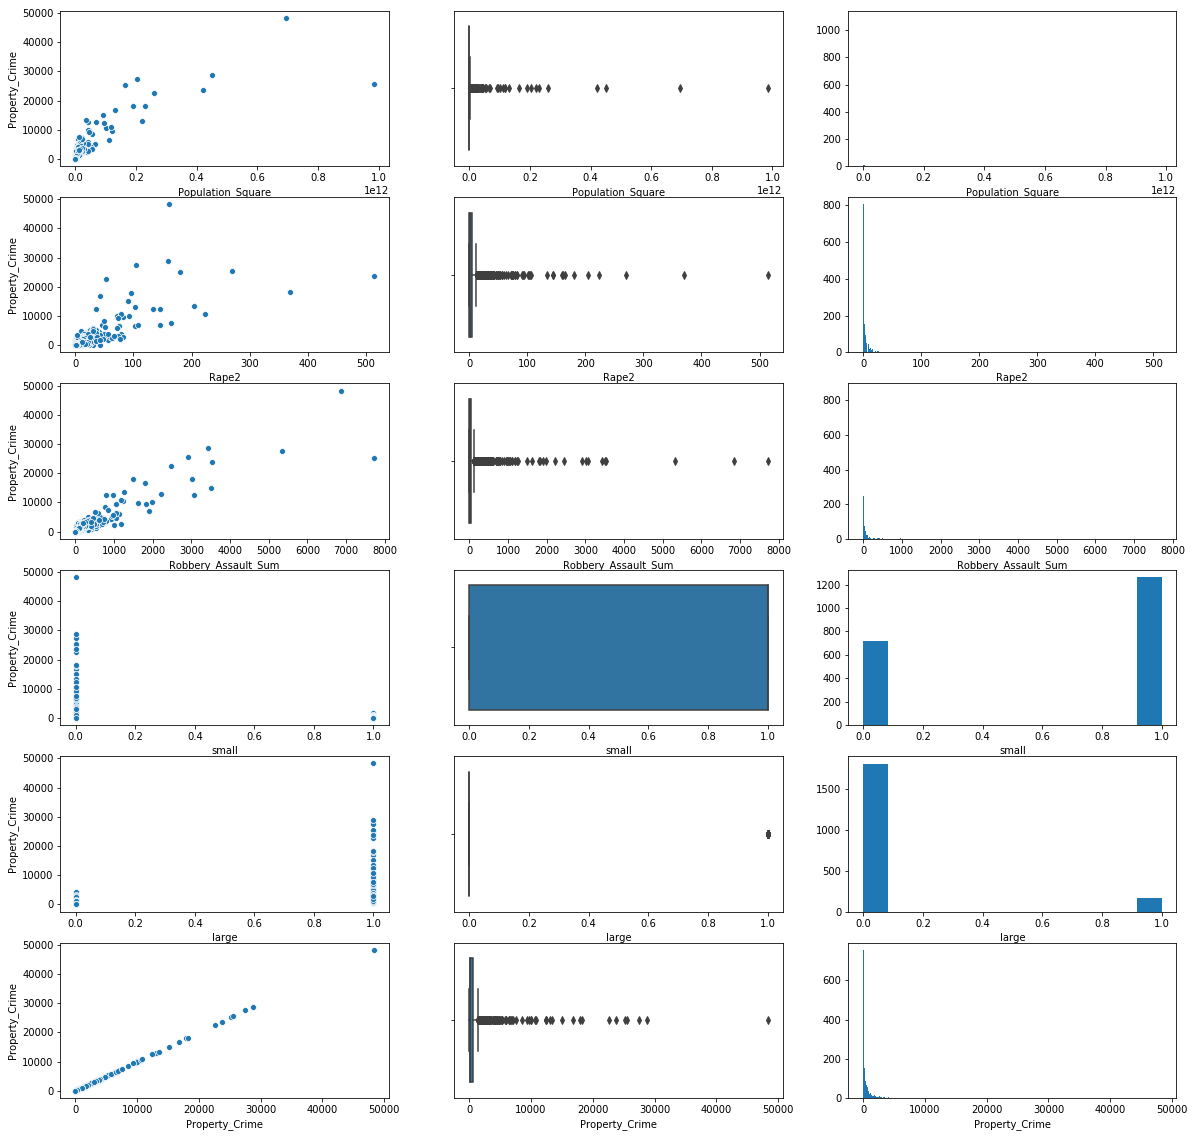

In [8]:
my_plot_loop(train_X,train_Y)